# Extract biometrics from segmentation results

## Volumetry

Literature

In [ ]:
from cmath import pi

# Measures
# GLOBE
# The means for the horizontal and vertical diameters are 24.26 ± 0.96 mm (n = 518) and 24.16 ± 0.97 mm (n = 510), respectively.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3432692/#:~:text=In%20the%20adult%2C%20the%20spherical,11.8%20and%2011.2%20mm%2C%20respectively
globe_avg_diameter = 24.2 # mm
globe_avg_volume = 4/3*pi*((globe_avg_diameter/2)**3) # mm³
print(globe_avg_volume)

Compute volumes

In [ ]:
import os
import numpy as np
import nibabel as nb

METHOD = 'reg'

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = np.zeros(len_path)
vol_lens = np.zeros(len_path)
vol_globe = np.zeros(len_path)
vol_nerve = np.zeros(len_path)
vol_int_fat = np.zeros(len_path)
vol_ext_fat = np.zeros(len_path)
vol_lat_mus = np.zeros(len_path)
vol_med_mus = np.zeros(len_path)
vol_inf_mus = np.zeros(len_path)
vol_sup_mus = np.zeros(len_path)
vol_total = np.zeros(len_path)

i=0
for folder1 in sorted(os.listdir(input_path)):

    # Load image in array format
    if METHOD=='reg': lab_arr = nb.load(f'{input_path}{folder1}/labels.nii.gz').get_fdata()
    elif METHOD=='dl': lab_arr = nb.load(f'{input_path}{folder1}').get_fdata()

    # Subject's name
    if METHOD=='reg': name_subject[i] = folder1
    elif METHOD=='dl': name_subject[i] = folder1.split('_')[0]
    print(f'subject: {name_subject[i]}')

    # Total volumetry of the subject's eye
    total_vol = np.count_nonzero(lab_arr)
    vol_total[i] = total_vol # / total_vol
    print(f'Total volume of the eye: {total_vol} mm³')

    # Lens
    vol_lens[i] = np.count_nonzero(lab_arr==1) # / total_vol
    print(f'lens {vol_lens[i]}')

    # Globe
    vol_globe[i] = np.count_nonzero(lab_arr==2) # / total_vol
    print(f'globe {vol_globe[i]}')

    # Nerve
    vol_nerve[i] = np.count_nonzero(lab_arr==3) # / total_vol
    print(f'nerve {vol_nerve[i]}')

    # Intraconal fat
    vol_int_fat[i] = np.count_nonzero(lab_arr==4) # / total_vol
    print(f'intraconal fat {vol_int_fat[i]}')

    # Extraconal fat
    vol_ext_fat[i] = np.count_nonzero(lab_arr==5) # / total_vol
    print(f'extraconal fat {vol_ext_fat[i]}')

    # Lateral rectus muscle
    vol_lat_mus[i] = np.count_nonzero(lab_arr==6) # / total_vol
    print(f'lateral rectus muscle {vol_lat_mus[i]}')

    # Medial rectus muscle
    vol_med_mus[i] = np.count_nonzero(lab_arr==7) # / total_vol
    print(f'medial rectus muscle {vol_med_mus[i]}')

    # Inferior rectus muscle
    vol_inf_mus[i] = np.count_nonzero(lab_arr==8) # / total_vol
    print(f'medial rectus muscle {vol_inf_mus[i]}')

    # Superior rectus muscle
    vol_sup_mus[i] = int(np.count_nonzero(lab_arr==9)) # / total_vol
    print(f'superior rectus muscle {vol_sup_mus[i]}')

    i+=1
    # if i==1:
    #     break

Save values into .csv

In [ ]:
import csv

if METHOD=='reg': filename = 'volumes_reg_total.csv'
elif METHOD=='dl': filename = 'volumes_dl.csv'

column_names = ['Subject','vol_lens','vol_globe','vol_nerve','vol_int_fat','vol_ext_fat','vol_lat_mus','vol_med_mus','vol_inf_mus','vol_sup_mus','vol_total']
vals = np.array([name_subject, vol_lens, vol_globe, vol_nerve, vol_int_fat, vol_ext_fat, vol_lat_mus, vol_med_mus, vol_inf_mus, vol_sup_mus, vol_total])
vals = vals.T
with open(main_path + filename, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    writer.writerows(vals)

Read values from .csv

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

METHOD = 'reg'

if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    filename = 'volumes_reg_norm.csv'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    filename = 'volumes_dl.csv'

df_vol = pd.read_csv(main_path + filename)

# lens
vol_lens = np.array([df_vol["vol_lens"]])
print(f'lens - mean: {np.mean(vol_lens)}, std: {np.std(vol_lens)}')

# globe
vol_globe = np.array([df_vol["vol_globe"]])
print(f'globe - mean: {np.mean(vol_globe)}, std: {np.std(vol_globe)}')

# nerve
vol_nerve = np.array([df_vol["vol_nerve"]])
print(f'nerve - mean: {np.mean(vol_nerve)}, std: {np.std(vol_nerve)}')

# intraconal fat
vol_int_fat = np.array([df_vol["vol_int_fat"]])
print(f'intraconal fat - mean: {np.mean(vol_int_fat)}, std: {np.std(vol_int_fat)}')

# extraconal fat
vol_ext_fat = np.array([df_vol["vol_ext_fat"]])
print(f'extraconal fat - mean: {np.mean(vol_ext_fat)}, std: {np.std(vol_ext_fat)}')

# lateral rectus muscle
vol_lat_mus = np.array([df_vol["vol_lat_mus"]])
print(f'lateral rectus muscle - mean: {np.mean(vol_lat_mus)}, std: {np.std(vol_lat_mus)}')

# medial rectus muscle
vol_med_mus= np.array([df_vol["vol_med_mus"]])
print(f'medial rectus muscle - mean: {np.mean(vol_med_mus)}, std: {np.std(vol_med_mus)}')

# inferior rectus muscle
vol_inf_mus = np.array([df_vol["vol_inf_mus"]])
print(f'inferior rectus muscle - mean: {np.mean(vol_inf_mus)}, std: {np.std(vol_inf_mus)}')

# superior rectus muscle
vol_sup_mus = np.array([df_vol["vol_sup_mus"]])
print(f'superior rectus muscle - mean: {np.mean(vol_sup_mus)}, std: {np.std(vol_sup_mus)}')

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig.suptitle('Volume per label (mm³)')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# lens
ax[0][0].set_title(f'lens - mean: {np.round(np.mean(vol_lens))}, std: {np.round(np.std(vol_lens), 2)}')
graph_lens = sns.boxplot(df_vol['vol_lens'], ax=ax[0][0])
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])

# globe
ax[0][1].set_title(f'globe - mean: {np.round(np.mean(vol_globe))}, std: {np.round(np.std(vol_globe), 2)}')
graph_globe = sns.boxplot(df_vol['vol_globe'], ax=ax[0][1])
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][1].set_ylim([2500, 9000])

# nerve
ax[0][2].set_title(f'nerve - mean: {np.round(np.mean(vol_nerve))}, std: {np.round(np.std(vol_nerve), 2)}')
graph_nerve = sns.boxplot(df_vol['vol_nerve'], ax=ax[0][2])
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][2].set_ylim([300, 1100])

# intraconal fat
ax[0][3].set_title(f'int fat - mean: {np.round(np.mean(vol_int_fat))}, std: {np.round(np.std(vol_int_fat), 2)}')
graph_int_fat = sns.boxplot(df_vol['vol_int_fat'], ax=ax[0][3])
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][3].set_ylim([2000, 7000])

# extraconal fat
ax[0][4].set_title(f'ext fat - mean: {np.round(np.mean(vol_ext_fat))}, std: {np.round(np.std(vol_ext_fat), 2)}')
graph_ext_fat = sns.boxplot(df_vol['vol_ext_fat'], ax=ax[0][4])
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][4].set_ylim([1000, 7000])

# lateral rectus muscle
ax[1][0].set_title(f'lat mus - mean: {np.round(np.mean(vol_lat_mus))}, std: {np.round(np.std(vol_lat_mus), 2)}')
graph_lat_mus = sns.boxplot(df_vol['vol_ext_fat'], ax=ax[1][0])
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([1000, 8000])    

# medial rectus muscle
ax[1][1].set_title(f'med mus - mean: {np.round(np.mean(vol_med_mus))}, std: {np.round(np.std(vol_med_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_med_mus'], ax=ax[1][1])
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][1].set_ylim([400, 1500])

# inferior rectus muscle
ax[1][2].set_title(f'inf mus - mean: {np.round(np.mean(vol_inf_mus))}, std: {np.round(np.std(vol_inf_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_inf_mus'], ax=ax[1][2])
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1300])

# superior rectus muscle
ax[1][3].set_title(f'sup mus - mean: {np.round(np.mean(vol_sup_mus))}, std: {np.round(np.std(vol_sup_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_sup_mus'], ax=ax[1][3])
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][3].set_ylim([300, 2000])     

plt.show

plt.savefig(main_path + filename.split('.')[0] + '_boxplot_norm.png')

Concatenate csv and group by sex

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px

# Concat csv in one dataframe (metadata + volumes per label)

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
csv_volumes = '/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg_total.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_volumes= pd.read_csv(csv_volumes)

# Dataframe
df = pd.concat([pd_metadata, pd_volumes.iloc[:, 1:]], axis=1, verify_integrity=True)

# Group by sex (males and females)
sex_group = df.groupby(["Sex"], dropna=True)

Males

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Male group
male_group = sex_group.get_group("M").dropna() 

# lens
vol_lens = np.array([male_group["vol_lens"]])
print(f'lens - mean: {np.mean(vol_lens)}, std: {np.std(vol_lens)}')

# globe
vol_globe = np.array([male_group["vol_globe"]])
print(f'globe - mean: {np.mean(vol_globe)}, std: {np.std(vol_globe)}')

# nerve
vol_nerve = np.array([male_group["vol_nerve"]])
print(f'nerve - mean: {np.mean(vol_nerve)}, std: {np.std(vol_nerve)}')

# intraconal fat
vol_int_fat = np.array([male_group["vol_int_fat"]])
print(f'intraconal fat - mean: {np.mean(vol_int_fat)}, std: {np.std(vol_int_fat)}')

# extraconal fat
vol_ext_fat = np.array([male_group["vol_ext_fat"]])
print(f'extraconal fat - mean: {np.mean(vol_ext_fat)}, std: {np.std(vol_ext_fat)}')

# lateral rectus muscle
vol_lat_mus = np.array([male_group["vol_lat_mus"]])
print(f'lateral rectus muscle - mean: {np.mean(vol_lat_mus)}, std: {np.std(vol_lat_mus)}')

# medial rectus muscle
vol_med_mus= np.array([male_group["vol_med_mus"]])
print(f'medial rectus muscle - mean: {np.mean(vol_med_mus)}, std: {np.std(vol_med_mus)}')

# inferior rectus muscle
vol_inf_mus = np.array([male_group["vol_inf_mus"]])
print(f'inferior rectus muscle - mean: {np.mean(vol_inf_mus)}, std: {np.std(vol_inf_mus)}')

# superior rectus muscle
vol_sup_mus = np.array([male_group["vol_sup_mus"]])
print(f'superior rectus muscle - mean: {np.mean(vol_sup_mus)}, std: {np.std(vol_sup_mus)}')

# total
vol_total = np.array([male_group["vol_total"]])
print(f'total - mean: {np.mean(vol_total)}, std: {np.std(vol_total)}')

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig.suptitle('Volume per label (mm³) in MALES')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# lens
ax[0][0].set_title(f'lens - mean: {np.round(np.mean(vol_lens))}, std: {np.round(np.std(vol_lens), 2)}')
graph_lens = sns.boxplot(vol_lens, ax=ax[0][0])
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])

# globe
ax[0][1].set_title(f'globe - mean: {np.round(np.mean(vol_globe))}, std: {np.round(np.std(vol_globe), 2)}')
graph_globe = sns.boxplot(vol_globe, ax=ax[0][1])
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][1].set_ylim([2500, 9000])

# nerve
ax[0][2].set_title(f'nerve - mean: {np.round(np.mean(vol_nerve))}, std: {np.round(np.std(vol_nerve), 2)}')
graph_nerve = sns.boxplot(vol_nerve, ax=ax[0][2])
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][2].set_ylim([300, 1100])

# intraconal fat
ax[0][3].set_title(f'int fat - mean: {np.round(np.mean(vol_int_fat))}, std: {np.round(np.std(vol_int_fat), 2)}')
graph_int_fat = sns.boxplot(vol_int_fat, ax=ax[0][3])
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][3].set_ylim([2000, 7000])

# extraconal fat
ax[0][4].set_title(f'ext fat - mean: {np.round(np.mean(vol_ext_fat))}, std: {np.round(np.std(vol_ext_fat), 2)}')
graph_ext_fat = sns.boxplot(vol_ext_fat, ax=ax[0][4])
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][4].set_ylim([1000, 7000])

# lateral rectus muscle
ax[1][0].set_title(f'lat mus - mean: {np.round(np.mean(vol_lat_mus))}, std: {np.round(np.std(vol_lat_mus), 2)}')
graph_lat_mus = sns.boxplot(vol_lat_mus, ax=ax[1][0])
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([1000, 8000])    

# medial rectus muscle
ax[1][1].set_title(f'med mus - mean: {np.round(np.mean(vol_med_mus))}, std: {np.round(np.std(vol_med_mus), 2)}')
graph_med_mus = sns.boxplot(vol_med_mus, ax=ax[1][1])
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][1].set_ylim([400, 1500])

# inferior rectus muscle
ax[1][2].set_title(f'inf mus - mean: {np.round(np.mean(vol_inf_mus))}, std: {np.round(np.std(vol_inf_mus), 2)}')
graph_med_mus = sns.boxplot(vol_inf_mus, ax=ax[1][2])
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1300])

# superior rectus muscle
ax[1][3].set_title(f'sup mus - mean: {np.round(np.mean(vol_sup_mus))}, std: {np.round(np.std(vol_sup_mus), 2)}')
graph_med_mus = sns.boxplot(vol_sup_mus, ax=ax[1][3])
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][3].set_ylim([300, 2000])    

# total
ax[1][4].set_title(f'total - mean: {np.round(np.mean(vol_total))}, std: {np.round(np.std(vol_total), 2)}')
graph_total = sns.boxplot(vol_total, ax=ax[1][4])
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][4].set_ylim([300, 2000])  

plt.show

plt.savefig('/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg_males.png')

Females

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Female group
female_group = sex_group.get_group("F").dropna() 

# lens
vol_lens = np.array([female_group["vol_lens"]])
print(f'lens - mean: {np.mean(vol_lens)}, std: {np.std(vol_lens)}')

# globe
vol_globe = np.array([female_group["vol_globe"]])
print(f'globe - mean: {np.mean(vol_globe)}, std: {np.std(vol_globe)}')

# nerve
vol_nerve = np.array([female_group["vol_nerve"]])
print(f'nerve - mean: {np.mean(vol_nerve)}, std: {np.std(vol_nerve)}')

# intraconal fat
vol_int_fat = np.array([female_group["vol_int_fat"]])
print(f'intraconal fat - mean: {np.mean(vol_int_fat)}, std: {np.std(vol_int_fat)}')

# extraconal fat
vol_ext_fat = np.array([female_group["vol_ext_fat"]])
print(f'extraconal fat - mean: {np.mean(vol_ext_fat)}, std: {np.std(vol_ext_fat)}')

# lateral rectus muscle
vol_lat_mus = np.array([female_group["vol_lat_mus"]])
print(f'lateral rectus muscle - mean: {np.mean(vol_lat_mus)}, std: {np.std(vol_lat_mus)}')

# medial rectus muscle
vol_med_mus= np.array([female_group["vol_med_mus"]])
print(f'medial rectus muscle - mean: {np.mean(vol_med_mus)}, std: {np.std(vol_med_mus)}')

# inferior rectus muscle
vol_inf_mus = np.array([female_group["vol_inf_mus"]])
print(f'inferior rectus muscle - mean: {np.mean(vol_inf_mus)}, std: {np.std(vol_inf_mus)}')

# superior rectus muscle
vol_sup_mus = np.array([female_group["vol_sup_mus"]])
print(f'superior rectus muscle - mean: {np.mean(vol_sup_mus)}, std: {np.std(vol_sup_mus)}')

# total
vol_total = np.array([female_group["vol_total"]])
print(f'total - mean: {np.mean(vol_total)}, std: {np.std(vol_total)}')

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig.suptitle('Volume per label (mm³) in FEMALES')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# lens
ax[0][0].set_title(f'lens - mean: {np.round(np.mean(vol_lens))}, std: {np.round(np.std(vol_lens), 2)}')
graph_lens = sns.boxplot(vol_lens, ax=ax[0][0])
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])

# globe
ax[0][1].set_title(f'globe - mean: {np.round(np.mean(vol_globe))}, std: {np.round(np.std(vol_globe), 2)}')
graph_globe = sns.boxplot(vol_globe, ax=ax[0][1])
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][1].set_ylim([2500, 9000])

# nerve
ax[0][2].set_title(f'nerve - mean: {np.round(np.mean(vol_nerve))}, std: {np.round(np.std(vol_nerve), 2)}')
graph_nerve = sns.boxplot(vol_nerve, ax=ax[0][2])
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][2].set_ylim([300, 1100])

# intraconal fat
ax[0][3].set_title(f'int fat - mean: {np.round(np.mean(vol_int_fat))}, std: {np.round(np.std(vol_int_fat), 2)}')
graph_int_fat = sns.boxplot(vol_int_fat, ax=ax[0][3])
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][3].set_ylim([2000, 7000])

# extraconal fat
ax[0][4].set_title(f'ext fat - mean: {np.round(np.mean(vol_ext_fat))}, std: {np.round(np.std(vol_ext_fat), 2)}')
graph_ext_fat = sns.boxplot(vol_ext_fat, ax=ax[0][4])
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][4].set_ylim([1000, 7000])

# lateral rectus muscle
ax[1][0].set_title(f'lat mus - mean: {np.round(np.mean(vol_lat_mus))}, std: {np.round(np.std(vol_lat_mus), 2)}')
graph_lat_mus = sns.boxplot(vol_lat_mus, ax=ax[1][0])
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([1000, 8000])    

# medial rectus muscle
ax[1][1].set_title(f'med mus - mean: {np.round(np.mean(vol_med_mus))}, std: {np.round(np.std(vol_med_mus), 2)}')
graph_med_mus = sns.boxplot(vol_med_mus, ax=ax[1][1])
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][1].set_ylim([400, 1500])

# inferior rectus muscle
ax[1][2].set_title(f'inf mus - mean: {np.round(np.mean(vol_inf_mus))}, std: {np.round(np.std(vol_inf_mus), 2)}')
graph_med_mus = sns.boxplot(vol_inf_mus, ax=ax[1][2])
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1300])

# superior rectus muscle
ax[1][3].set_title(f'sup mus - mean: {np.round(np.mean(vol_sup_mus))}, std: {np.round(np.std(vol_sup_mus), 2)}')
graph_med_mus = sns.boxplot(vol_sup_mus, ax=ax[1][3])
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][3].set_ylim([300, 2000])

# total
ax[1][4].set_title(f'total - mean: {np.round(np.mean(vol_total))}, std: {np.round(np.std(vol_total), 2)}')
graph_total = sns.boxplot(vol_total, ax=ax[1][4])
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][4].set_ylim([300, 2000])  

plt.show

plt.savefig('/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg_females.png')

Males and females together

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Male group
male_group = sex_group.get_group("M").dropna()

# Female group
female_group = sex_group.get_group("F").dropna()

# lens
vol_lens_male = np.array([male_group["vol_lens"]])
vol_lens_female = np.array([female_group["vol_lens"]])

# globe
vol_globe_male = np.array([male_group["vol_globe"]])
vol_globe_female = np.array([female_group["vol_globe"]])

# nerve
vol_nerve_male = np.array([male_group["vol_nerve"]])
vol_nerve_female = np.array([female_group["vol_nerve"]])

# intraconal fat
vol_int_fat_male = np.array([male_group["vol_int_fat"]])
vol_int_fat_female = np.array([female_group["vol_int_fat"]])

# extraconal fat
vol_ext_fat_male = np.array([male_group["vol_ext_fat"]])
vol_ext_fat_female = np.array([female_group["vol_ext_fat"]])

# lateral rectus muscle
vol_lat_mus_male = np.array([male_group["vol_lat_mus"]])
vol_lat_mus_female = np.array([female_group["vol_lat_mus"]])

# medial rectus muscle
vol_med_mus_male = np.array([male_group["vol_med_mus"]])
vol_med_mus_female = np.array([male_group["vol_med_mus"]])

# inferior rectus muscle
vol_inf_mus_male = np.array([male_group["vol_inf_mus"]])
vol_inf_mus_female = np.array([female_group["vol_inf_mus"]])

# superior rectus muscle
vol_sup_mus_male = np.array([male_group["vol_sup_mus"]])
vol_sup_mus_female = np.array([male_group["vol_sup_mus"]])

# total
vol_total_male = np.array([male_group["vol_total"]])
vol_total_female = np.array([female_group["vol_total"]])

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 10, figsize=(16*k, 9*k))
plt.subplots_adjust(wspace=0.8, hspace=0.2)
fig.suptitle('Volume per label (mm³) per sex')
fig.patch.set_facecolor('white')
fix_axis = True
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# Legend
legend_elements = [Line2D([0], [0], color='c', lw=2, label='Males'),
    Line2D([0], [0], color='orange', lw=2, label='Females')]
fig.legend(handles=legend_elements, loc='upper right')
# fig.tight_layout(pad = 1)

# lens male
ax[0][0].set_title(f'{np.round(np.mean(vol_lens_male))} +/- {np.round(np.std(vol_lens_male), 2)}')
graph_lens = sns.boxplot(vol_lens_male, ax=ax[0][0], color='c')
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])
    ax[0][0].set_xlabel('lens')
    ax[0][0].tick_params(labelbottom=False, bottom=False)

# lens female
ax[0][1].set_title(f'{np.round(np.mean(vol_lens_female))} +/- {np.round(np.std(vol_lens_female), 2)}')
graph_lens = sns.boxplot(vol_lens_female, ax=ax[0][1], color='orange')
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][1].set_ylim([0, 160])
    ax[0][1].set_xlabel('lens')
    ax[0][1].tick_params(labelbottom=False, bottom=False)

# globe male
ax[0][2].set_title(f'{np.round(np.mean(vol_globe_male))} +/- {np.round(np.std(vol_globe_male), 2)}')
graph_globe = sns.boxplot(vol_globe_male, ax=ax[0][2], color='c')
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][2].set_ylim([2500, 9000])
    ax[0][2].set_xlabel('globe')
    ax[0][2].tick_params(labelbottom=False, bottom=False)

# globe female
ax[0][3].set_title(f'{np.round(np.mean(vol_globe_female))} +/- {np.round(np.std(vol_globe_female), 2)}')
graph_globe = sns.boxplot(vol_globe_female, ax=ax[0][3], color='orange')
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][3].set_ylim([2500, 9000])
    ax[0][3].set_xlabel('globe')
    ax[0][3].tick_params(labelbottom=False, bottom=False)

# nerve male 
ax[0][4].set_title(f'{np.round(np.mean(vol_nerve_male))} +/- {np.round(np.std(vol_nerve_male), 2)}')
graph_nerve = sns.boxplot(vol_nerve_male, ax=ax[0][4], color='c')
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][4].set_ylim([300, 1100])
    ax[0][4].set_xlabel('nerve')
    ax[0][4].tick_params(labelbottom=False, bottom=False)

# nerve female 
ax[0][5].set_title(f'{np.round(np.mean(vol_nerve_female))} +/- {np.round(np.std(vol_nerve_female), 2)}')
graph_nerve = sns.boxplot(vol_nerve_female, ax=ax[0][5], color='orange')
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][5].set_ylim([300, 1100])
    ax[0][5].set_xlabel('nerve')
    ax[0][5].tick_params(labelbottom=False, bottom=False)

# intraconal fat male
ax[0][6].set_title(f'{np.round(np.mean(vol_int_fat_male))} +/- {np.round(np.std(vol_int_fat_male), 2)}')
graph_int_fat = sns.boxplot(vol_int_fat_male, ax=ax[0][6], color='c')
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][6].set_ylim([2000, 7000])
    ax[0][6].set_xlabel('int fat')
    ax[0][6].tick_params(labelbottom=False, bottom=False)

# intraconal fat female
ax[0][7].set_title(f'{np.round(np.mean(vol_int_fat_female))} +/- {np.round(np.std(vol_int_fat_female), 2)}')
graph_int_fat = sns.boxplot(vol_int_fat_female, ax=ax[0][7], color='orange')
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][7].set_ylim([2000, 7000])
    ax[0][7].set_xlabel('int fat')
    ax[0][7].tick_params(labelbottom=False, bottom=False)

# extraconal fat male
ax[0][8].set_title(f'{np.round(np.mean(vol_ext_fat_male))} +/- {np.round(np.std(vol_ext_fat_male), 2)}')
graph_ext_fat = sns.boxplot(vol_ext_fat_male, ax=ax[0][8], color='c')
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][8].set_ylim([1000, 8000])
    ax[0][8].set_xlabel('ext fat')
    ax[0][8].tick_params(labelbottom=False, bottom=False)

# extraconal fat female
ax[0][9].set_title(f'{np.round(np.mean(vol_ext_fat_female))} +/- {np.round(np.std(vol_ext_fat_female), 2)}')
graph_ext_fat = sns.boxplot(vol_ext_fat_female, ax=ax[0][9], color='orange')
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][9].set_ylim([1000, 8000])
    ax[0][9].set_xlabel('ext fat')
    ax[0][9].tick_params(labelbottom=False, bottom=False)

# lateral rectus muscle male
ax[1][0].set_title(f'{np.round(np.mean(vol_lat_mus_male))} +/- {np.round(np.std(vol_lat_mus_male), 2)}')
graph_lat_mus = sns.boxplot(vol_lat_mus_male, ax=ax[1][0], color='c')
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([300, 1100])
    ax[1][0].set_xlabel('lat mus')
    ax[1][0].tick_params(labelbottom=False, bottom=False)

# lateral rectus muscle female
ax[1][1].set_title(f'{np.round(np.mean(vol_lat_mus_female))} +/- {np.round(np.std(vol_lat_mus_female), 2)}')
graph_lat_mus = sns.boxplot(vol_lat_mus_female, ax=ax[1][1], color='orange')
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][1].set_ylim([300, 1100]) 
    ax[1][1].set_xlabel('lat mus') 
    ax[1][1].tick_params(labelbottom=False, bottom=False)

# medial rectus muscle male
ax[1][2].set_title(f'{np.round(np.mean(vol_med_mus_male))} +/- {np.round(np.std(vol_med_mus_male), 2)}')
graph_med_mus = sns.boxplot(vol_med_mus_male, ax=ax[1][2], color='c')
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1700])
    ax[1][2].set_xlabel('med mus')
    ax[1][2].tick_params(labelbottom=False, bottom=False)

# medial rectus muscle female
ax[1][3].set_title(f'{np.round(np.mean(vol_med_mus_female))} +/- {np.round(np.std(vol_med_mus_female), 2)}')
graph_med_mus = sns.boxplot(vol_med_mus_female, ax=ax[1][3], color='orange')
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][3].set_ylim([400, 1700])
    ax[1][3].set_xlabel('med mus')
    ax[1][3].tick_params(labelbottom=False, bottom=False)

# inferior rectus muscle male
ax[1][4].set_title(f'{np.round(np.mean(vol_inf_mus_male))} +/- {np.round(np.std(vol_inf_mus_male), 2)}')
graph_med_mus = sns.boxplot(vol_inf_mus_male, ax=ax[1][4], color='c')
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][4].set_ylim([400, 1300])
    ax[1][4].set_xlabel('inf mus')
    ax[1][4].tick_params(labelbottom=False, bottom=False)

# inferior rectus muscle female
ax[1][5].set_title(f'{np.round(np.mean(vol_inf_mus_female))} +/- {np.round(np.std(vol_inf_mus_female), 2)}')
graph_med_mus = sns.boxplot(vol_inf_mus_female, ax=ax[1][5], color='orange')
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][5].set_ylim([400, 1300])
    ax[1][5].set_xlabel('inf mus')
    ax[1][5].tick_params(labelbottom=False, bottom=False)

# superior rectus muscle male
ax[1][6].set_title(f'{np.round(np.mean(vol_sup_mus_male))} +/- {np.round(np.std(vol_sup_mus_male), 2)}')
graph_med_mus = sns.boxplot(vol_sup_mus_male, ax=ax[1][6], color='c')
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][6].set_ylim([500, 2600])
    ax[1][6].set_xlabel('sup mus')
    ax[1][6].tick_params(labelbottom=False, bottom=False)

# superior rectus muscle female
ax[1][7].set_title(f'{np.round(np.mean(vol_sup_mus_female))} +/- {np.round(np.std(vol_sup_mus_female), 2)}')
graph_med_mus = sns.boxplot(vol_sup_mus_female, ax=ax[1][7], color='orange')
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][7].set_ylim([500, 2600])
    ax[1][7].set_xlabel('sup mus')
    ax[1][7].tick_params(labelbottom=False, bottom=False)

# total male
ax[1][8].set_title(f'{np.round(np.mean(vol_total_male))} +/- {np.round(np.std(vol_total_male), 2)}')
graph_total = sns.boxplot(vol_total_male, ax=ax[1][8], color='c')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][8].set_ylim([10000, 28000])  
    ax[1][8].set_xlabel('Total')
    ax[1][8].tick_params(labelbottom=False, bottom=False)

# total female
ax[1][9].set_title(f'{np.round(np.mean(vol_total_female))} +/-{np.round(np.std(vol_total_female), 2)}')
graph_total = sns.boxplot(vol_total_female, ax=ax[1][9], color='orange')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][9].set_ylim([10000, 28000])
    ax[1][9].set_xlabel('Total')
    ax[1][9].tick_params(labelbottom=False, bottom=False)

plt.show

plt.savefig('/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg_males_females.png')

## Axial length

### regionprops + line 2D

subject: 2022160102320
com_lens: [121 201  73]
com_eyeball: [124 192  75]
com_nerve: [116 170  71]
slices: [73 72 71] 

slice 73 -- voxels -- lens: 29 | nerve: 54 | int fat: 115 | globe: 402
```````````right eye: lens: 29 | nerve: 54 | int fat: 115 | globe: 402
com_lens: [121. 201.]
axis minor lens = 4.537016011163064 
axis major lens = 8.160140899981657
Number of points of the line in the image space: 256
Number of intersection points in lens: 5
Lens extreme intersection point: [121 203]
Number of instersection points in globe: 18
Globe extreme intersection point: [121 181]
grad_arr = [219.1874198  176.7766953   23.25134405 146.32925203 150.15408752
  60.25466787  49.08220146 206.69935897 189.8836815   67.31688124
   9.86154146  14.54518821   2.23606798  12.39455526   4.37321392
   6.75462804   4.96235831   4.27200187   1.25         7.15017482
   0.90138782   3.80788655   5.59016994   3.13249102   4.03112887
   1.52069063   1.82002747   3.40036763   3.40036763   2.23606798
   6.020797

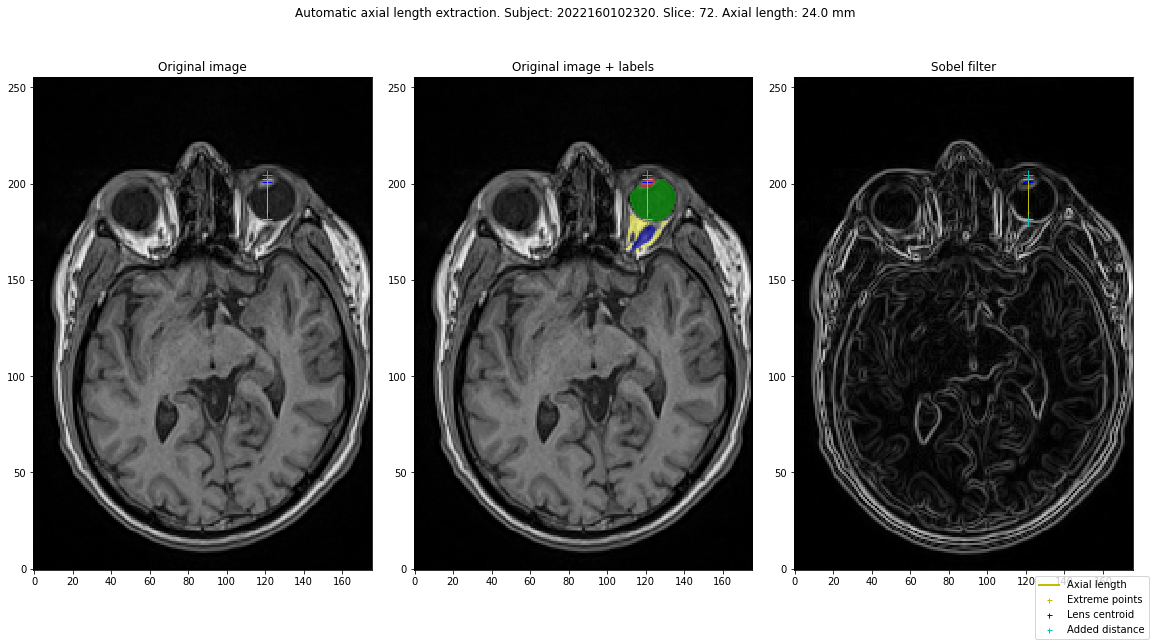

In [3]:
import os, glob
from pathlib import Path
import numpy as np
import nibabel as nb
from skimage.measure import regionprops, label
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import math
from skimage import filters

METHOD = 'nnunet' # reg, dl, manual, nn

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
    input_path_ima = main_path + 'non_labeled_dataset_nifti_cropped/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'
elif METHOD=='manual':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/'
    input_path = main_path + 'a123/'
elif METHOD=='nnunet': 
    input_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/non_labeled_dataset_nifti_nnunet/'
    lab_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/no_postprocessing/'
output_path = '/mnt/sda1/Repos/a-eye/Output/axial_length/nnUNet/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = [None]*len_path
axial_length_total = np.zeros(len_path)
outliers_list_1 = list() # condition 1
outliers_list_2 = list() # condition 2
outliers_list_3 = list() # condition 3
outliers_list_4 = list() # condition 3
outliers_dict = {}
list_results = sorted(os.listdir(input_path))

i=0
for folder1 in list_results:
    # if folder1 == '2022160101890': # uncomment for concrete subject
    if folder1 == 'AEye_2022160102320_0000.nii.gz': # for nnunet

        # Subject's name
        if METHOD=='dl': name_subject[i] = folder1.split('_')[0]
        elif METHOD=='nnunet': name_subject[i] = folder1.split('_')[1]
        else: name_subject[i] = str(folder1)
        print(f'subject: {name_subject[i]}')

        # Load image in array format
        if METHOD=='reg':
            lab = nb.load(f'{input_path}{folder1}/labels.nii.gz')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
            ima = nb.load(f'{input_path_ima}{folder1}_cropped.nii.gz')
            ima_arr = ima.get_fdata() # image matrix
        elif METHOD=='dl':
            lab = nb.load(f'{input_path}{folder1}')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
        elif METHOD=='manual':
            lab = nb.load(f'{input_path}{folder1}/input/{folder1}_labels_cropped.nii.gz')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
        elif METHOD=='nnunet':
            lab = nb.load(f'{lab_path}AEye_{name_subject[i]}.nii.gz')
            lab_arr = lab.get_fdata() # labels matrix
            voxel_size = lab.header.get_zooms() # voxel size
            ima = nb.load(f'{input_path}{folder1}')
            ima_arr = ima.get_fdata() # image matrix
        
        # Label masks
        lens = (lab_arr==1)*1
        globe = (lab_arr==2)*1
        eyeball = (np.logical_or(lab_arr==1, lab_arr==2))*1 # *1 to convert it to int instead of bool
        nerve = (lab_arr==3)*1
        if np.count_nonzero(lens)==0 or np.count_nonzero(nerve)==0 or np.count_nonzero(globe)==0:
            outliers_list_1.append(name_subject[i]) # outliers with no lens segmented
        else:
            # LENS CENTROID
            properties_lens = regionprops(lens) # properties
            com_lens = (np.rint(properties_lens[0].centroid)).astype(int) # centroid
            print(f'com_lens: {np.around(com_lens)}')

            # EYEBALL CENTROID
            properties_eyeball = regionprops(eyeball) # properties
            com_eyeball = (np.rint(properties_eyeball[0].centroid)).astype(int) # centroid
            print(f'com_eyeball: {np.around(com_eyeball)}')
            
            # OPTIC NERVE CENTROID
            properties_nerve = regionprops(nerve) # properties
            com_nerve = (np.rint(properties_nerve[0].centroid)).astype(int) # centroid
            print(f'com_nerve: {np.around(com_nerve)}')

            # Compute best centroid
            if com_lens[2] == com_nerve[2]:
                slices = np.array([com_lens[2]])
            else:
                if com_lens[2] < com_nerve[2]:
                    slices = np.arange(com_lens[2], com_nerve[2]+1, 1, dtype=int)
                else: 
                    slices = np.arange(com_lens[2], com_nerve[2]-1, -1, dtype=int)
            print(f'slices: {slices} \n')

            for s in slices:
                lens_vox = np.count_nonzero(lab_arr[:, :, s]==1)
                globe_vox = np.count_nonzero(lab_arr[:, :, s]==2)
                nerve_vox = np.count_nonzero(lab_arr[:, :, s]==3)
                int_fat_vox = np.count_nonzero(lab_arr[:, :, s]==4)
                print(f'slice {s} -- voxels -- lens: {lens_vox} | nerve: {nerve_vox} | int fat: {int_fat_vox} | globe: {globe_vox}')

                # Label masks
                lens_2d = (lab_arr[:, :, s]==1)*1
                globe_2d = (lab_arr[:, :, s]==2)*1
                nerve_2d = (lab_arr[:, :, s]==3)*1
                int_fat_2d = (lab_arr[:, :, s]==4)*1
                if METHOD=='nnunet':
                    lens_2d_q = lens_2d[int(np.around(lens_2d.shape[0]/2)):lens_2d.shape[0], int(np.around(lens_2d.shape[1]/2)):lens_2d.shape[1]] # quadrant right eye
                    globe_2d_q = globe_2d[int(np.around(globe_2d.shape[0]/2)):globe_2d.shape[0], int(np.around(globe_2d.shape[1]/2)):globe_2d.shape[1]] # quadrant right eye
                    nerve_2d_q = nerve_2d[int(np.around(nerve_2d.shape[0]/2)):nerve_2d.shape[0], int(np.around(nerve_2d.shape[1]/2)):nerve_2d.shape[1]] # quadrant right eye
                    int_fat_2d_q = int_fat_2d[int(np.around(int_fat_2d.shape[0]/2)):int_fat_2d.shape[0], int(np.around(int_fat_2d.shape[1]/2)):int_fat_2d.shape[1]] # quadrant right eye
                    lens_vox_2d = np.count_nonzero(lens_2d_q)
                    globe_vox_2d = np.count_nonzero(globe_2d_q)
                    nerve_vox_2d = np.count_nonzero(nerve_2d_q)
                    int_fat_vox_2d = np.count_nonzero(int_fat_2d_q)
                    print(f'```````````right eye: lens: {lens_vox_2d} | nerve: {nerve_vox_2d} | int fat: {int_fat_vox_2d} | globe: {globe_vox_2d}')

                # Centroid of the lens in the 2D slice in axial view
                # Check first if there are voxels of all the structures below in the right upper quadrant
                if np.count_nonzero(lens_2d_q)!=0 and np.count_nonzero(nerve_2d_q)!=0 and np.count_nonzero(int_fat_2d_q)!=0 and np.count_nonzero(globe_2d_q)!=0:
                    if METHOD=='nnunet':
                        properties_lens = regionprops(lens_2d_q) # properties
                    else:
                        properties_lens = regionprops(lens_2d)
                    com_lens = properties_lens[0].centroid # centroid
                    if METHOD=='nnunet':
                        com_lens = [com_lens[0]+lens_2d.shape[0]/2, com_lens[1]+lens_2d.shape[1]/2] # centroid amplified to entire image
                    print(f'com_lens: {np.around(com_lens)}')
                    axis_minor_lens = properties_lens[0].axis_minor_length # minor axis
                    axis_major_lens = properties_lens[0].axis_major_length # major axis
                    print(f'axis minor lens = {axis_minor_lens} \naxis major lens = {axis_major_lens}')

                    # Get the 2nd point of the orthogonal in the lens
                    x0_lens = com_lens[0]
                    y0_lens = com_lens[1]
                    x1_lens = x0_lens
                    y1_lens = y0_lens - 1 # orthogonal to the globe (following y axis: orientation y=1, z=0)

                    # Parametric equation of the line between (y0, z0) and (y1, z1)
                    n_points = int(np.ceil(math.dist([0,0], [lab_arr.shape[1], lab_arr.shape[2]]))) # max number of points of a line in the image square
                    t = np.linspace(-int(n_points), int(n_points), n_points*10)
                    line_y = (y0_lens - y1_lens)*t + y0_lens
                    line_x = (x0_lens - x1_lens)*t + x0_lens

                    # Line in image space (square)
                    line = np.zeros([lab_arr.shape[0], lab_arr.shape[1]])
                    for j in range(len(t)):
                        if 0<=round(line_y[j])<lab_arr.shape[1] and 0<=round(line_x[j])<lab_arr.shape[0]:
                            line[int(np.around(line_x[j])), int(np.around(line_y[j]))] = 1
                    print(f'Number of points of the line in the image space: {np.count_nonzero(line)}')

                    # Intersections and extreme points
                    # Lens
                    # inter_lens = np.logical_and(lens[:, :, int(np.around(com_eyeball[2]))], line)*1 # int format, intersection points in lens with line
                    inter_lens = np.logical_and(lens_2d, line)*1 # int format, intersection points in lens with line
                    print(f'Number of intersection points in lens: {np.count_nonzero(inter_lens)}')
                    if np.count_nonzero(inter_lens) > 0:
                        inter_coord_lens = np.argwhere(inter_lens==1)
                        extreme_inter_lens = inter_coord_lens[np.argmax(inter_coord_lens[:,1])]
                        print(f'Lens extreme intersection point: {extreme_inter_lens}')
                        # Globe
                        # inter_globe = np.logical_and(globe[:, :, int(np.around(com_eyeball[2]))], line)*1 # int format, intersection points in globe with line
                        inter_globe = np.logical_and(globe_2d, line)*1 # int format, intersection points in globe with line
                        print(f'Number of instersection points in globe: {np.count_nonzero(inter_globe)}')
                        inter_coord_globe = np.argwhere(inter_globe==1)
                        extreme_inter_globe = inter_coord_globe[np.argmin(inter_coord_globe[:,1])]
                        print(f'Globe extreme intersection point: {extreme_inter_globe}')

                        # Line to compute the intensities gradient
                        sobel = True
                        if sobel:
                            edges = filters.sobel(ima_arr[:, :, s]) # Sobel
                            grad_arr = edges[extreme_inter_lens[0], extreme_inter_lens[1]:lab_arr.shape[1]-1] # Sobel
                        else:
                            grad_arr = ima_arr[extreme_inter_lens[0], extreme_inter_lens[1]:lab_arr.shape[1]-1, s]
                        print(f'grad_arr = {grad_arr}')
                        vox = 0
                        if len(grad_arr) >= 1:
                            for v in range(len(grad_arr)):
                                next_val = grad_arr[v+1] if v != len(grad_arr)-1 else 3000
                                if sobel:
                                    threshold = 50
                                    if (grad_arr[v] > next_val and next_val >= 100) or (next_val - grad_arr[v] <= threshold and next_val - grad_arr[v] >= 0): # Sobel
                                        vox += 1
                                    else:
                                        break
                                else:
                                    threshold = 50
                                    if (grad_arr[v] > next_val and next_val >= 100) or (next_val - grad_arr[v] <= threshold and next_val - grad_arr[v] >= 0):
                                        vox += 1
                                    else:
                                        break
                        print(f'Number of mm to add to the axial length = {vox}')

                        # Extra distance 2 (towards globe direction until reaching intraconal fat)
                        grad_arr2 = lab_arr[extreme_inter_globe[0], np.arange(extreme_inter_globe[1]-1, 0, -1), s]
                        print(f'grad_arr2 = {grad_arr2}')
                        vox2 = 0
                        if len(grad_arr2) > 0 and np.count_nonzero(grad_arr2 == 4) > 0 :
                            for w in range(len(grad_arr2)):
                                if grad_arr2[w] != 4:
                                    vox2 +=1
                                else:
                                    break
                        print(f'Number of mm to add to the axial length = {vox2}')

                        # Axial length
                        axial_length = (extreme_inter_lens[1] + voxel_size[1]/2) - (extreme_inter_globe[1] - voxel_size[1]/2) + vox + vox2 # distance between the center of the two points, we have to add +0.5mm for each point to be the actual extremes
                        print(f'Axial length = {axial_length} mm \n')

                        if axial_length < 28 and axial_length > 18: # condition 4
                            axial_length_total[i] = axial_length

                            # PLOT
                            plot_bool = True
                            if plot_bool:
                                k = 1 # aspect ratio
                                fig, ax = plt.subplots(1, 3, figsize=(16*k, 9*k))
                                fig.patch.set_facecolor('white')
                                fig.suptitle(f'Automatic axial length extraction. Subject: {name_subject[i]}. Slice: {s}. Axial length: {axial_length} mm')

                                # Legend
                                legend_elements = [Line2D([0], [0], color='y', lw=2, label=f'Axial length'),
                                    Line2D([], [], color='y', label='Extreme points', marker='+', markersize=5, linestyle='None'),
                                    Line2D([], [], color='b', label='Lens centroid', marker='+', markersize=5, linestyle='None'),
                                    Line2D([], [], color='c', label='Added distance', marker='+', markersize=5, linestyle='None')]
                                fig.legend(handles=legend_elements, loc='lower right')
                                fig.tight_layout()

                                # Lens centroid and line
                                ax[0].set_title('Original image')
                                ax[0].imshow(ima_arr[:, :, s].T, origin='lower', cmap='gist_gray', interpolation='none')
                                # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
                                ax[0].plot(int(np.around(com_lens[0])), int(np.around(com_lens[1])), '+b', markersize=10)
                                ax[0].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2, '+y', markersize=10)
                                ax[0].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2, '+y', markersize=10)
                                ax[0].plot((extreme_inter_lens[0], extreme_inter_globe[0]), (extreme_inter_lens[1]+voxel_size[1]/2, extreme_inter_globe[1]-voxel_size[1]/2), '-y', linewidth=1)
                                # Extra distance
                                ax[0].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2+vox, '+c', markersize=10)
                                ax[0].plot((extreme_inter_lens[0], extreme_inter_lens[0]), (extreme_inter_lens[1]+voxel_size[1]/2+vox, extreme_inter_lens[1]), '-c', linewidth=1)
                                # Extra distance 2
                                ax[0].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2-vox2, '+c', markersize=10)
                                ax[0].plot((extreme_inter_globe[0], extreme_inter_globe[0]), (extreme_inter_globe[1]-voxel_size[1]/2-vox2, extreme_inter_globe[1]), '-c', linewidth=1)

                                # Eyeball
                                ax[1].set_title('Original image + labels')
                                ax[1].imshow(ima_arr[:, :, s].T, origin='lower', cmap='gist_gray', interpolation='none')
                                lens_mask = np.ma.masked_where(lens[:, :, s] == 0, lens[:, :, s])
                                globe_mask = np.ma.masked_where(globe[:, :, s] == 0, globe[:, :, s])
                                nerve_mask = np.ma.masked_where(nerve[:, :, s] == 0, nerve[:, :, s])
                                int_fat_mask = np.ma.masked_where(int_fat_2d[:, :] == 0, int_fat_2d[:, :])
                                palette_lens = colors.ListedColormap(['red'])
                                palette_globe = colors.ListedColormap(['lime'])
                                palette_nerve = colors.ListedColormap(['blue'])
                                palette_int_fat = colors.ListedColormap(['yellow'])
                                ax[1].imshow(lens_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_lens)
                                ax[1].imshow(globe_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_globe)
                                ax[1].imshow(nerve_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_nerve)
                                ax[1].imshow(int_fat_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_int_fat)
                                # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
                                ax[1].plot(int(np.around(com_lens[0])), int(np.around(com_lens[1])), '+b', markersize=10)
                                ax[1].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2, '+y', markersize=10)
                                ax[1].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2, '+y', markersize=10)
                                ax[1].plot((extreme_inter_lens[0], extreme_inter_globe[0]), (extreme_inter_lens[1]+voxel_size[1]/2, extreme_inter_globe[1]-voxel_size[1]/2), '-y', linewidth=1)
                                # Extra distance
                                ax[1].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2+vox, '+c', markersize=10)
                                ax[1].plot((extreme_inter_lens[0], extreme_inter_lens[0]), (extreme_inter_lens[1]+voxel_size[1]/2+vox, extreme_inter_lens[1]), '-c', linewidth=1)
                                # Extra distance 2
                                ax[1].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2-vox2, '+c', markersize=10)
                                ax[1].plot((extreme_inter_globe[0], extreme_inter_globe[0]), (extreme_inter_globe[1]-voxel_size[1]/2-vox2, extreme_inter_globe[1]), '-c', linewidth=1)

                                # Sobel
                                edges = filters.sobel(ima_arr[:, :, s].T)
                                ax[2].set_title('Sobel filter')
                                ax[2].imshow(edges, origin='lower', cmap='gist_gray', interpolation='none')
                                lens_mask = np.ma.masked_where(lens[:, :, s] == 0, lens[:, :, s])
                                globe_mask = np.ma.masked_where(globe[:, :, s] == 0, globe[:, :, s])
                                nerve_mask = np.ma.masked_where(nerve[:, :, s] == 0, nerve[:, :, s])
                                palette_lens = colors.ListedColormap(['red'])
                                palette_globe = colors.ListedColormap(['lime'])
                                palette_nerve = colors.ListedColormap(['blue'])
                                # ax[2].imshow(lens_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_lens)
                                # ax[2].imshow(globe_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_globe)
                                # ax[2].imshow(nerve_mask.T, origin='lower', interpolation='none', alpha=0.4, cmap=palette_nerve)
                                # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
                                ax[2].plot(int(np.around(com_lens[0])), int(np.around(com_lens[1])), '+b', markersize=10)
                                ax[2].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2, '+y', markersize=10)
                                ax[2].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2, '+y', markersize=10)
                                ax[2].plot((extreme_inter_lens[0], extreme_inter_globe[0]), (extreme_inter_lens[1]+voxel_size[1]/2, extreme_inter_globe[1]-voxel_size[1]/2), '-y', linewidth=1)
                                # Extra distance
                                ax[2].plot(extreme_inter_lens[0], extreme_inter_lens[1]+voxel_size[1]/2+vox, '+c', markersize=10)
                                ax[2].plot((extreme_inter_lens[0], extreme_inter_lens[0]), (extreme_inter_lens[1]+voxel_size[1]/2+vox, extreme_inter_lens[1]), '-c', linewidth=1)
                                # Extra distance 2
                                ax[2].plot((extreme_inter_globe[0], extreme_inter_globe[0]), (extreme_inter_globe[1]-voxel_size[1]/2-vox2, extreme_inter_globe[1]), '-c', linewidth=1)
                                ax[2].plot(extreme_inter_globe[0], extreme_inter_globe[1]-voxel_size[1]/2-vox2, '+c', markersize=10)

                                plt.show

                                # plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/axial_length/examples_v4_grad/fig_{i+1}.png')

                            break # comment to extract all the slices in the range lens centroid - optic nerve centroid

                        else:
                            axial_length = 0
                            outliers_list_4.append(name_subject[i])
                            outliers_list_4_clean = list(dict.fromkeys(outliers_list_4)) # to remove duplicates from list
                            outliers_dict[str(name_subject[i])] = s
                        
                    else:
                        axial_length = 0
                        outliers_list_3.append(name_subject[i])
                        outliers_list_3_clean = list(dict.fromkeys(outliers_list_3)) # to remove duplicates from list
                        outliers_dict[str(name_subject[i])] = s

                else:
                    axial_length = 0
                    outliers_list_2.append(name_subject[i])
                    outliers_list_clean = list(dict.fromkeys(outliers_list_2)) # to remove duplicates from list
                    outliers_dict[str(name_subject[i])] = s

            print(f'\n')

            # i+=1
            # if i==3:
            #     break

### Save values into .csv


In [ ]:
import csv

if METHOD=='reg': filename = 'axial_length_reg_v10_grad_th50.csv'
elif METHOD=='dl': filename = 'axial_length_dl_outliers.csv'
elif METHOD=='manual': filename = 'axial_length_manual.csv'
elif METHOD=='nnunet': filename = 'axial_length_nnunet_no_pp.csv'

column_names = ['Subject','axial_length']
vals = np.array([name_subject, axial_length_total])
vals = vals.T
with open(output_path + filename, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    writer.writerows(vals)

### Read values from .csv

In [ ]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np

ref_axl_mean = 24.1 # mm. Range: (21.6-27). See https://bmcophthalmol.biomedcentral.com/articles/10.1186/s12886-022-02289-y
ref_axl_std = 1.2 # mm

csv_manual = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/axial_length_manual.csv'
csv_reg = '/mnt/sda1/Repos/a-eye/Output/axial_length/axial_length_reg_v3_grad.csv'
# csv_dl = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/3D_multilabel/experiment_0/axial_length_dl_outliers.csv'
csv_dl = '/mnt/sda1/Repos/a-eye/Output/axial_length/axial_length_reg_v3_grad_correct.csv'

df_axial_manual = pd.read_csv(csv_manual)
df_axial_reg = pd.read_csv(csv_reg)
df_axial_dl = pd.read_csv(csv_dl)

# Data from .csv
axl_manual = np.array([df_axial_manual["axial_length"]])
axl_reg = np.array([df_axial_reg["axial_length"]])
axl_dl = np.array([df_axial_dl["axial_length"]])
axl_dl = axl_dl[axl_dl != 0]
print(len(axl_dl))
print(f'MANUAL: axial length mean: {np.around(np.mean(axl_manual), 1)}, std: {np.std(axl_manual)}\n\
ATLAS-BASED: axial length mean: {np.around(np.mean(axl_reg), 1)}, std: {np.std(axl_reg)}\n\
DEEP LEARNING: axial length mean: {np.around(np.mean(axl_dl), 1)}, std: {np.std(axl_dl)}')

# Subplots
k = 1 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Axial length (mm)')
fig.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Legend
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Previous studies \nmean: {ref_axl_mean} \nstd: {ref_axl_std}')]
fig.legend(handles=legend_elements, loc='center right')

# # Manual
# ax[0].set_title(f'MANUAL (35 subs) - mean: {np.around(np.mean(axl_manual), decimals=1)}, std: {np.around(np.std(axl_manual), decimals=1)}')
# graph_lens = sns.boxplot(axl_manual, ax=ax[0])
# # graph_lens = sns.swarmplot(axl_manual, ax=ax[0])
# graph_lens.axhline(ref_axl_mean, color='red')
# # ax[0].set_xticklabels()
# if fix_axis:
#     # ax[0].set_xlim(x_axis)
#     ax[0].set_ylim(y_axis)

meanlineprops = dict(linestyle="-.", linewidth=2.5, color="lime")
meanpointprops = {"marker":"D", "markerfacecolor":"lime", "markeredgecolor":"black", "markersize":"10"}

# ATLAS-based reg
ax[0].set_title(f'ATLAS ({axl_reg.shape[1]} subs) - mean: {np.around(np.mean(axl_reg), decimals=1)}, std: {np.around(np.std(axl_reg), decimals=1)}')
graph_lens = sns.boxplot(axl_reg, ax=ax[0], meanprops=meanlineprops, showmeans=True, meanline=True)
graph_lens.axhline(ref_axl_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[0].set_ylim(y_axis)

# Deep learning
ax[1].set_title(f'ATLAS v2 ({len(axl_dl)} subs) - mean: {np.around(np.mean(axl_dl), decimals=1)}, std: {np.around(np.std(axl_dl), decimals=1)}')
graph_lens = sns.boxplot(axl_dl, ax=ax[1], meanprops=meanlineprops, showmeans=True, meanline=True)
graph_lens.axhline(ref_axl_mean, color='red')
if fix_axis:
    # ax[2].set_xlim(x_axis)
    ax[1].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/axial_length/boxplots_axial_length_v2_floor_min_axis.png')

## Metadata

Age, Sex, Height, Weight, BMI (= weight/height² [kg/m²])

In [ ]:
import SimpleITK as sitk
import sys, os, glob
import pydicomext as pydcm
from pydicom.fileset import FileSet
from deid.data import get_dataset
from deid.dicom import get_files, get_identifiers
from pathlib import Path

input_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = [None]*len_path
age_subject = [None]*len_path
sex_subject = [None]*len_path
height_subject = [None]*len_path
weight_subject = [None]*len_path
bmi_subject = [None]*len_path

# Create sorted list
i=0
list_subs = [None]*len_path
for folder1 in sorted(os.listdir(input_path)):
    list_subs[i] = folder1
    i+=1

# Start subloop from specific subject (0 if it's from the beginning)
index_sub = list_subs.index('2022160103683') # index_sub = 0 # if it's from the beginning
print(f'subject index: {index_sub}')

# Loop sublist
k=0
for j in range(index_sub, len_path):

    dicom_folder = f'{input_path}{list_subs[j]}/I_Kopf_t1_mpr_tra_iso_p2/'
    dicom_files = sorted(glob.glob(os.path.join(dicom_folder, "*.dcm")))
    ids = get_identifiers(dicom_files)

    # print(ids[dicom_files[0]].keys())

    # ID
    field_id = ids[dicom_files[0]]['(0010, 0020)']
    id = field_id.element.value
    name_subject[j] = id
    print(f'subject: {id}')

    # Sex
    field_sex = ids[dicom_files[0]]['(0010, 0040)']
    sex = field_sex.element.value
    sex_subject[j] = sex
    print(f'sex: {sex}')
    # name = field_sex.name
    # uid = field_sex.uid

    # Age
    field_age = ids[dicom_files[0]]['(0010, 1010)']
    age = field_age.element.value
    age = age[1:3]
    age_subject[j] = age
    print(f'age: {age}')

    # Height
    try:
        field_height = ids[dicom_files[0]]['(0010, 1020)']
        height = field_height.element.value
        height_subject[j] = height
    except KeyError:
        field_height = None
        height = None
        height_subject[j] = None
    print(f'height: {height} m')

    # Weight
    field_weight = ids[dicom_files[0]]['(0010, 1030)']
    weight = field_weight.element.value
    weight_subject[j] = weight
    print(f'weight: {weight} kg')

    # BMI (kg/m²)
    if height != None:
        bmi_subject[j] = weight / (height**2)
    print(f'BMI: {bmi_subject[j]} kg/m²')

    k+=1
    # if k==1:
    #     break

### Save values to .csv

In [ ]:
import csv
import numpy as np

column_names = ['Subject','Sex','Age','Height','Weight','BMI']
vals = np.array([name_subject, sex_subject, age_subject, height_subject, weight_subject, bmi_subject])
vals = vals.T
vals = vals[index_sub:]

if index_sub != 0:
    # Reader
    with open('/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv', 'r') as read_file:
        reader = csv.reader(read_file)
        lines = list(reader)
        lines = lines[0:index_sub+1]
        lines.extend(list(vals))
# Writer
with open('/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv', 'w') as write_file:
    writer = csv.writer(write_file)
    if index_sub==0: # only writing columns if not starting from the first subject
        writer.writerow(column_names)
        lines = vals
    writer.writerows(lines)

read_file.close()
write_file.close()

### Read values from.csv

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px

csv_file = '/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv'
pd_csv = pd.read_csv(csv_file)

# Data from .csv
sex_csv = np.array([pd_csv["Sex"]], dtype='<U7')
age_csv = np.array([pd_csv["Age"]])
num_males = np.count_nonzero(np.char.count(sex_csv, "M"))
num_females = np.count_nonzero(np.char.count(sex_csv, "F"))

print(f'mean age is: {np.around(np.mean(age_csv), 1)}, std: {int(np.std(age_csv))}, min age is: {np.amin(age_csv)}, max age is: {np.amax(age_csv)}')
print(f'men: {num_males}, women: {num_females}')

# Sex group using pandas
sex_group = pd_csv.groupby(["Sex"], dropna=True)

# Print sex group
# for name, group in sex_group:
#     print(name)
#     print(group)

# Male group
male_group = sex_group.get_group("M").dropna() # group by male and remove NaN values
bmi_male = np.array([male_group["BMI"]])
mean_bmi_male = np.around(np.mean(bmi_male), decimals=1)
std_bmi_male = np.around(np.std(bmi_male), decimals=1)
underweight_male = np.count_nonzero(bmi_male<18.5)
non_overweight_male = np.count_nonzero(np.logical_and(18.5<=bmi_male, bmi_male<25))
overweight_male = np.count_nonzero(np.logical_and(25<=bmi_male, bmi_male<30))
obese_male = np.count_nonzero(bmi_male>=30)
print(f'- MALES ({male_group.shape[0]}): \n     BMI = {np.around(mean_bmi_male, 1)} +- {np.around(std_bmi_male, 1)} kg/m² \
Underweight: {underweight_male}; Non-overweight: {non_overweight_male}; Overweight: {overweight_male}; Obese: {obese_male}')

# Female group
female_group = sex_group.get_group("F").dropna() # group by female and remove NaN values (there is one that has no height)
bmi_female = np.array([female_group["BMI"]])
mean_bmi_female = np.around(np.mean(bmi_female), decimals=1)
std_bmi_female = np.around(np.std(bmi_female), decimals=1)
underweight_female = np.count_nonzero(bmi_female<18.5)
non_overweight_female = np.count_nonzero(np.logical_and(18.5<=bmi_female, bmi_female<25))
overweight_female = np.count_nonzero(np.logical_and(25<=bmi_female, bmi_female<30))
obese_female = np.count_nonzero(bmi_female>=30)
print(f'- FEMALES ({female_group.shape[0]}): \n     BMI = {np.around(mean_bmi_female, 1)} +- {np.around(std_bmi_female, 1)} kg/m² \
Underweight: {underweight_female}; Non-overweight: {non_overweight_female}; Overweight: {overweight_female}; Obese: {obese_female}')

# Total
print(f'- TOTAL ({male_group.shape[0] + female_group.shape[0]}): \n     Underweight: {underweight_female + underweight_male}; \
Non-overweight: {non_overweight_female + non_overweight_male}; Overweight: {overweight_female + overweight_male}; \
Obese: {obese_female + obese_male}')


# PLOT #

# Sex
fig1 = plt.figure(figsize=(5,5))
fig1.patch.set_facecolor('white')
plt.bar(('Males', 'Females'), (num_males, num_females))
plt.xlabel('Sex')
plt.ylabel('Number of subjects')
plt.title(f'Number of subjects grouped by sex ({num_males+num_females} subjects)')
plt.show()
# plt.savefig('/mnt/sda1/Repos/a-eye/Output/sex_bargraph.png')

# Age
age_counts = pd_csv["Age"].value_counts()
fig2 = px.bar(age_counts, title=f'Distribution of age ({num_males+num_females} subjects)')
fig2.update_layout(
    xaxis_title = 'Age',
    yaxis_title = 'Frequency',
    title_x = 0.5,
    showlegend = False
)
fig2.show()
fig2.write_image('/mnt/sda1/Repos/a-eye/Output/age_bargraph.png')

# BMI
bmi_labels = ('Underweight', 'Non-overweight', 'Overweight', 'Obese')
bmi_percentages_male = np.array([underweight_male, non_overweight_male, overweight_male, obese_male]) / male_group.shape[0]
bmi_percentages_female = np.array([underweight_female, non_overweight_female, overweight_female, obese_female]) / female_group.shape[0]
bmi_colors = ('tab:red','tab:blue','tab:orange','tab:green')
fig3, axs3 = plt.subplots(1, 2, figsize=(10, 5))
fig3.patch.set_facecolor('white')
fig3.suptitle(f'BMI classification ({num_males+num_females} subjects)')
axs3[0].pie(bmi_percentages_male, labels=bmi_labels, startangle=45, colors=bmi_colors, autopct='%1.1f%%')
axs3[0].axis('equal'), axs3[0].set_title(f'Males ({male_group.shape[0]})')
axs3[1].pie(bmi_percentages_female, labels=bmi_labels, startangle=45, colors=bmi_colors, autopct='%1.1f%%')
axs3[1].axis('equal'), axs3[1].set_title(f'Females ({female_group.shape[0]})')
plt.show()
# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_piechart.png')


## Axial length grouped by sex

In [ ]:
import pandas as pd
import numpy as np

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
csv_axial_length = '/mnt/sda1/Repos/a-eye/Output/axial_length/nnUNet/axial_length_nnunet_no_pp.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_axial_length = pd.read_csv(csv_axial_length)

# Dataframe
# df = pd.concat((pd_metadata, pd_axial_length), ignore_index=False) # concatenates one after the other
df = pd.concat([pd_metadata, pd_axial_length['axial_length']], axis=1, verify_integrity=True)

# Group by sex
sex_group = df.groupby(["Sex"])

# Male group
male_group = sex_group.get_group("M").dropna()
axial_length_male = np.array([male_group["axial_length"]])
axial_length_male = axial_length_male[axial_length_male != 0]
mean_al_male = np.around(np.mean(axial_length_male), decimals=1)
std_al_male = np.around(np.std(axial_length_male), decimals=1)
print(f'- MALES: \n   Axial length: {mean_al_male} +- {std_al_male} mm')

# Female group
female_group = sex_group.get_group("F").dropna()
axial_length_female = np.array([female_group["axial_length"]])
axial_length_female = axial_length_female[axial_length_female != 0]
mean_al_female = np.around(np.mean(axial_length_female), decimals=1)
std_al_female = np.around(np.std(axial_length_female), decimals=1)
print(f'- FEMALES: \n   Axial length: {mean_al_female} +- {std_al_female} mm')

### Plot

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Literature (PlosOne Sönke). See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6366780/
ref_axl_male_mean = 23.4 # mm
ref_axl_male_std = 0.8 # mm
ref_axl_female_mean = 22.8 # mm
ref_axl_female_std = 0.9 # mm

# Subplots
k = 1 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Axial length grouped by sex (mm)')
fig.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,30]

# Legend
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Previous studies \n Male: {ref_axl_male_mean} +- {ref_axl_male_std} mm \
    \n Female: {ref_axl_female_mean} +- {ref_axl_female_std} mm'),
    Line2D([0], [0], color='lime', lw=2, label='Mean')]
fig.legend(handles=legend_elements, loc='lower right')
meanlineprops = dict(linestyle="solid", linewidth=1.5, color="lime")
meanpointprops = {"marker":"D", "markerfacecolor":"lime", "markeredgecolor":"black", "markersize":"10"}

# ATLAS - MALES
ax[0].set_title(f'ATLAS MALES ({len(axial_length_male)} subs) - mean: {mean_al_male}, std: {std_al_male}')
graph_lens = sns.boxplot(axial_length_male, ax=ax[0], meanprops=meanlineprops, meanline=True, showmeans=True)
graph_lens.axhline(ref_axl_male_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[0].set_ylim(y_axis)

# ATLAS - FEMALES
ax[1].set_title(f'ATLAS FEMALES ({len(axial_length_female)} subs) - mean: {mean_al_female}, std: {std_al_female}')
graph_lens = sns.boxplot(axial_length_female, ax=ax[1], meanprops=meanlineprops, meanline=True, showmeans=True)
graph_lens.axhline(ref_axl_female_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[1].set_ylim(y_axis)

plt.show

# plt.savefig(f'{output_path}boxplots_axial_length_nnunet_no_pp.png')

## Volumetry and BMI

Concatenate csv's and group by sex

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px

# Concat csv in one dataframe (metadata + volumes per label)

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
csv_volumes = '/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_volumes= pd.read_csv(csv_volumes)

# Dataframe
df = pd.concat([pd_metadata, pd_volumes.iloc[:, 1:]], axis=1, verify_integrity=True)

# Group by sex (males and females)
sex_group = df.groupby(["Sex"], dropna=True)

### Scatter plots

Males

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lens_male.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_male.flatten(), y=volume_globe_male.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_male.flatten(), y=volume_nerve_male.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_male.flatten(), y=volume_int_fat_male.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_male.flatten(), y=volume_ext_fat_male.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lat_mus_male.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_male.flatten(), y=volume_med_mus_male.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_inf_mus_male.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_sup_mus_male.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Females

In [ ]:
# Female group
female_group = sex_group.get_group("F").dropna() 

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig2, ax2 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig2.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig2.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax2[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lens_female.flatten(), ax=ax2[0][0])
ax2[0][0].set_xlabel('BMI (kg/m²)')
ax2[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][0].set_ylim(y_axis)

# Globe
ax2[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_female.flatten(), y=volume_globe_female.flatten(), ax=ax2[0][1])
ax2[0][1].set_xlabel('BMI (kg/m²)')
ax2[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][1].set_ylim(y_axis)

# Optic nerve
ax2[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_female.flatten(), y=volume_nerve_female.flatten(), ax=ax2[0][2])
ax2[0][2].set_xlabel('BMI (kg/m²)')
ax2[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][2].set_ylim(y_axis)

# Intraconal fat
ax2[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_female.flatten(), y=volume_int_fat_female.flatten(), ax=ax2[0][3])
ax2[0][3].set_xlabel('BMI (kg/m²)')
ax2[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][3].set_ylim(y_axis)

# Extraconal fat
ax2[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_female.flatten(), y=volume_ext_fat_female.flatten(), ax=ax2[0][4])
ax2[0][4].set_xlabel('BMI (kg/m²)')
ax2[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax2[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lat_mus_female.flatten(), ax=ax2[1][0])
ax2[1][0].set_xlabel('BMI (kg/m²)')
ax2[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax2[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_female.flatten(), y=volume_med_mus_female.flatten(), ax=ax2[1][1])
ax2[1][1].set_xlabel('BMI (kg/m²)')
ax2[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax2[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_inf_mus_female.flatten(), ax=ax2[1][2])
ax2[1][2].set_xlabel('BMI (kg/m²)')
ax2[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax2[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_sup_mus_female.flatten(), ax=ax2[1][3])
ax2[1][3].set_xlabel('BMI (kg/m²)')
ax2[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][3].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_females_norm.png')

### Check normal distribution

#### MALES

Graph

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna()

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.distplot(volume_lens_male.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('Volume (mm³)')
ax1[0][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.distplot(volume_globe_male.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('Volume (mm³)')
ax1[0][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.distplot(volume_nerve_male.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('Volume (mm³)')
ax1[0][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.distplot(volume_int_fat_male.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('Volume (mm³)')
ax1[0][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.distplot(volume_ext_fat_male.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('Volume (mm³)')
ax1[0][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.distplot(volume_lat_mus_male.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('Volume (mm³)')
ax1[1][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.distplot(volume_med_mus_male.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('Volume (mm³)')
ax1[1][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.distplot(volume_inf_mus_male.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('Volume (mm³)')
ax1[1][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot9 = sns.distplot(volume_sup_mus_male.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('Volume (mm³)')
ax1[1][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][4].set_title(f'BMI')
plot10 = sns.distplot(bmi_male.flatten(), ax=ax1[1][4])
ax1[1][4].set_xlabel('BMI')
ax1[1][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][4].set_ylim(y_axis)

plt.show

plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/dist_gaussian_vol_bmi_males.png')

Shapiro-Wilk test

In [ ]:
from scipy import stats

alpha = 0.05

# LENS
statistic, p_value = stats.shapiro(volume_lens_male.flatten())
print(f"LENS \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# GLOBE
statistic, p_value = stats.shapiro(volume_globe_male.flatten())
print(f"GLOBE \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# OPTIC NERVE
statistic, p_value = stats.shapiro(volume_nerve_male.flatten())
print(f"OPTIC NERVE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INTRACONAL FAT
statistic, p_value = stats.shapiro(volume_int_fat_male.flatten())
print(f"INTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# EXTRACONAL FAT
statistic, p_value = stats.shapiro(volume_ext_fat_male.flatten())
print(f"EXTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# LATERAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_lat_mus_male.flatten())
print(f"LATERAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# MEDIAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_med_mus_male.flatten())
print(f"MEDIAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# SUPERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_sup_mus_male.flatten())
print(f"SUPERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INFERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_inf_mus_male.flatten())
print(f"INFERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# BMI
statistic, p_value = stats.shapiro(bmi_male.flatten())
print(f"BMI \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

#### FEMALES

Graph

In [ ]:
# Female group
female_group = sex_group.get_group("F").dropna()

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.distplot(volume_lens_female.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('Volume (mm³)')
ax1[0][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.distplot(volume_globe_female.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('Volume (mm³)')
ax1[0][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.distplot(volume_nerve_female.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('Volume (mm³)')
ax1[0][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.distplot(volume_int_fat_female.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('Volume (mm³)')
ax1[0][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.distplot(volume_ext_fat_female.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('Volume (mm³)')
ax1[0][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.distplot(volume_lat_mus_female.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('Volume (mm³)')
ax1[1][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.distplot(volume_med_mus_female.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('Volume (mm³)')
ax1[1][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.distplot(volume_inf_mus_female.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('Volume (mm³)')
ax1[1][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot9 = sns.distplot(volume_sup_mus_female.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('Volume (mm³)')
ax1[1][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][4].set_title(f'BMI')
plot10 = sns.distplot(bmi_female.flatten(), ax=ax1[1][4])
ax1[1][4].set_xlabel('BMI')
ax1[1][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][4].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/dist_gaussian_vol_bmi_females.png')

Shapiro-Wilk test

In [ ]:
from scipy import stats

alpha = 0.05

# LENS
statistic, p_value = stats.shapiro(volume_lens_female.flatten())
print(f"LENS \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# GLOBE
statistic, p_value = stats.shapiro(volume_globe_female.flatten())
print(f"GLOBE \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# OPTIC NERVE
statistic, p_value = stats.shapiro(volume_nerve_female.flatten())
print(f"OPTIC NERVE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INTRACONAL FAT
statistic, p_value = stats.shapiro(volume_int_fat_female.flatten())
print(f"INTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# EXTRACONAL FAT
statistic, p_value = stats.shapiro(volume_ext_fat_female.flatten())
print(f"EXTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# LATERAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_lat_mus_female.flatten())
print(f"LATERAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# MEDIAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_med_mus_female.flatten())
print(f"MEDIAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# SUPERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_sup_mus_female.flatten())
print(f"SUPERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INFERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_inf_mus_female.flatten())
print(f"INFERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# BMI
statistic, p_value = stats.shapiro(bmi_female.flatten())
print(f"BMI \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

### Linear regression

In [ ]:
train_test = False
remove_outliers = False

#### Males

Prepare data

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# # Splitting into train and test sets

# Get all the columns from the dataframe.
columns = male_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# columns = ['vol_lens']
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = male_group.sample(frac=0.8, random_state=1)
else: train = male_group

# Select anything not in the training set and put it in the testing set.
test = male_group.loc[~male_group.index.isin(train.index)]

# Print the shapes of both sets.
print(train[columns].shape)
print(test.shape)

P values

In [ ]:
from sklearn.feature_selection import f_regression

ALPHA = 0.05
f_statistics, p_values = f_regression(train[columns], train[target]) # volumes with BMI

# print(f'p_value = {p_values}')
print(f'p_values \n Lens: {p_values[0]} \n Globe: {p_values[1]} \n Optic nerve: {p_values[2]} \n Intraconal fat: {p_values[3]} \
    \n Extraconal fat: {p_values[4]} \n Lateral rectus muscle: {p_values[5]} \n Medial rectus muscle: {p_values[6]} \
    \n Inferior rectus muscle: {p_values[7]} \n Superior rectus muscle: {p_values[8]}')

Train

In [ ]:
# Fitting a linear regression

# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma

# Initialize the model class.
model = linear_model.LinearRegression()
# model = linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data.
trained_model = model.fit(train[columns], train[target])

# Model score, intercept and  slope
intercept = trained_model.intercept_
slope = trained_model.coef_
print(f'R² score = {trained_model.score(train[columns], train[target])} \nIntercept = {intercept} \nSlope = {slope}')

Test

In [ ]:
# Predicting Error

# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

if train_test:
    # Generate our predictions for the test set.
    predictions = model.predict(test[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, test[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(test[target], predictions))
else:
    # Generate our predictions for the test set.
    predictions = model.predict(train[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, train[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(train[target], predictions))

Plot

In [ ]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Line per label (using intercept and slope)
def get_line_lens(x):
    return slope[0] * x + intercept
def get_line_globe(x):
    return slope[1] * x + intercept
def get_line_nerve(x):
    return slope[2] * x + intercept
def get_line_int_fat(x):
    return slope[3] * x + intercept
def get_line_ext_fat(x):
    return slope[4] * x + intercept
def get_line_lat_mus(x):
    return slope[5] * x + intercept
def get_line_med_mus(x):
    return slope[6] * x + intercept
def get_line_inf_mus(x):
    return slope[7] * x + intercept
def get_line_sup_mus(x):
    return slope[8] * x + intercept

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lens_male.flatten(), ax=ax1[0][0])
line_points = list(map(get_line_lens, volume_lens_male.flatten()))
line = Line2D(line_points, volume_lens_male.flatten(), color='red')
ax1[0][0].add_line(line)
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_male.flatten(), y=volume_globe_male.flatten(), ax=ax1[0][1])
line_points = list(map(get_line_globe, volume_globe_male.flatten()))
line = Line2D(line_points, volume_globe_male.flatten(), color='red')
ax1[0][1].add_line(line)
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_male.flatten(), y=volume_nerve_male.flatten(), ax=ax1[0][2])
line_points = list(map(get_line_nerve, volume_nerve_male.flatten()))
line = Line2D(line_points, volume_nerve_male.flatten(), color='red')
ax1[0][2].add_line(line)
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_male.flatten(), y=volume_int_fat_male.flatten(), ax=ax1[0][3])
line_points = list(map(get_line_int_fat, volume_int_fat_male.flatten()))
line = Line2D(line_points, volume_int_fat_male.flatten(), color='red')
ax1[0][3].add_line(line)
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_male.flatten(), y=volume_ext_fat_male.flatten(), ax=ax1[0][4])
line_points = list(map(get_line_ext_fat, volume_ext_fat_male.flatten()))
line = Line2D(line_points, volume_ext_fat_male.flatten(), color='red')
ax1[0][4].add_line(line)
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lat_mus_male.flatten(), ax=ax1[1][0])
line_points = list(map(get_line_lat_mus, volume_lat_mus_male.flatten()))
line = Line2D(line_points, volume_lat_mus_male.flatten(), color='red')
ax1[1][0].add_line(line)
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_male.flatten(), y=volume_med_mus_male.flatten(), ax=ax1[1][1])
line_points = list(map(get_line_med_mus, volume_med_mus_male.flatten()))
line = Line2D(line_points, volume_med_mus_male.flatten(), color='red')
ax1[1][1].add_line(line)
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_inf_mus_male.flatten(), ax=ax1[1][2])
line_points = list(map(get_line_inf_mus, volume_inf_mus_male.flatten()))
line = Line2D(line_points, volume_inf_mus_male.flatten(), color='red')
ax1[1][2].add_line(line)
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_sup_mus_male.flatten(), ax=ax1[1][3])
line_points = list(map(get_line_sup_mus, volume_sup_mus_male.flatten()))
line = Line2D(line_points, volume_sup_mus_male.flatten(), color='red')
ax1[1][3].add_line(line)
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Plot predictions

In [ ]:
# Plot outputs
if train_test:
    plt.scatter(test[target], predictions,  color='red')
else:
    plt.scatter(train[target], predictions, color='red')

plt.show()

Linear regression per label

In [ ]:
from sklearn.feature_selection import f_regression
# Import the linear models.
from sklearn.linear_model import LinearRegression, HuberRegressor
import statsmodels.api as sma
# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score
# Correlations
from scipy import stats

# Male group
male_group = sex_group.get_group("M").dropna()
print('MALES \n')

# Get all the columns from the dataframe.
columns = male_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = male_group.sample(frac=0.8, random_state=1)
else: train = male_group

# Select anything not in the training set and put it in the testing set.
test = male_group.loc[~male_group.index.isin(train.index)]

# Print the shapes of both sets.
print(f'Train shape: {train[columns].shape}')
print(f'Test shape: {test.shape} \n')

ALPHA = 0.05 # for the p values
# model = linear_model.LinearRegression() # linear model for the regression

# List labels
list_labels = ['Lens', 'Globe', 'Optic nerve', 'Intraconal fat', 'Extraconal fat', 'Lateral rectus muscle', 'Medial rectus muscle',
    'Inferior rectus muscle', 'Superior rectus muscle']

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])
volumes_male_list = np.array([volume_lens_male, volume_globe_male, volume_nerve_male, volume_int_fat_male, volume_ext_fat_male,
    volume_lat_mus_male, volume_med_mus_male, volume_inf_mus_male, volume_sup_mus_male])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label
# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig = plt.figure(figsize=(16*k, 9*k))
fig.patch.set_facecolor('white')
fig.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fix_axis = False
# x_axis = [-2, 2]
y_axis = [0, 9000]
# Legend
legend_elements = [Line2D([], [], color='red', lw=2, label=f'Huber regressor'),
    Line2D([], [], color='green', label='Linear regressor')]
fig.legend(handles=legend_elements, loc='upper right')

for n, c in enumerate(columns):

    print(list_labels[n])

    # print(train[c].shape)
    # print(train[target].shape)

    # 2D array having predictor and target
    arr = np.array([train[c], train[target]]).T # predictor, target
    print(f'Shape before removing outliers = {arr.shape}')

    # Remove outliers
    if remove_outliers == True:
        # Vol
        mean_vol = np.mean(arr[:,0])
        std_vol = np.std(arr[:,0])
        # Vol: mean - 2*std
        index_low_vol = list(np.array(np.where(arr[:,0] < (mean_vol - 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_vol, axis=0) # delete rows from array
        # Vol: mean + 2*std
        index_up_vol = list(np.array(np.where(arr[:,0] > (mean_vol + 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_vol, axis=0) # delete rows from array
        # BMI
        mean_bmi = np.mean(arr[:,1])
        std_bmi = np.std(arr[:,1])
        # BMI: mean - 2*std
        index_low_bmi = list(np.array(np.where(arr[:,1] < (mean_bmi - 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_bmi, axis=0) # delete rows from array
        # BMI: mean + 2*std
        index_up_bmi = list(np.array(np.where(arr[:,1] > (mean_bmi + 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_bmi, axis=0) # delete rows from array

    print(f'Shape after removing outliers = {arr.shape}')

    # Huber regressor
    train_c = np.reshape(np.array(train[c]), (-1, 1))
    train_target = np.array(train[target]).flatten()
    huber = HuberRegressor().fit(train_c, train_target)
    huber_score = huber.score(train_c, train_target)
    predictions = huber.predict(train_c)
    slope_huber = huber.coef_
    intercept_huber = huber.intercept_
    print(f'Slope Huber = {slope_huber} \nIntercept Huber = {intercept_huber} \nHuber score (R² score) = {huber_score}')

    # Linear regression
    result = stats.linregress(arr)
    slope_linear = result.slope
    intercept_linear = result.intercept
    r_value = result.rvalue
    p_value = result.pvalue
    stderr = result.stderr
    print(f'Slope linear= {slope_linear} \nIntercept linear = {intercept_linear} \nR value (Pearson) = {r_value} \nP value = {p_value} \nStderr = {stderr} \n')

    # Line per label (using intercept and slope)
    def get_line_huber(x):
        return slope_huber * x + intercept_huber
    def get_line_linear(x):
        return slope_linear * x + intercept_linear

    # Plot
    ax = plt.subplot(2, 5, n+1) # add a new subplot iteratively
    sns.scatterplot(y=bmi_male.flatten(), x=volumes_male_list[n].flatten(), ax=ax)
    line_points_huber = list(map(get_line_huber, volumes_male_list[n].flatten()))
    line_huber = Line2D(volumes_male_list[n].flatten(), line_points_huber, color='red')
    line_points_linear = list(map(get_line_linear, volumes_male_list[n].flatten()))
    line_linear= Line2D(volumes_male_list[n].flatten(), line_points_linear, color='green')
    if p_value < 0.001:
        ax.add_line(line_huber)
        # ax.add_line(line_linear)
    # Title and axis labels
    ax.set_title(list_labels[n])
    ax.set_ylabel('BMI (kg/m²)')
    ax.set_xlabel('Volume (mm³)')
    # Legend
    p_value_plot = f'= {p_value:.4f}' if p_value >= 0.001 else '< 0.001'
    labels = [f'R = {r_value:.4f} \nP {p_value_plot}']
    ax.legend(labels=labels, loc='upper right')
    # Axis
    if fix_axis:
        # ax.set_xlim(x_axis)
        ax.set_ylim(y_axis)

filename = 'bmi_vs_volume_males_linear_regression_outliers_mean' if remove_outliers else 'bmi_vs_volume_males_huber_regression'
plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/{filename}_inv.png')

#### Females

Prepare data

In [ ]:
# Female group
female_group = sex_group.get_group("F").dropna() 

# # Splitting into train and test sets

# Get all the columns from the dataframe.
columns = female_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI"]]

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = female_group.sample(frac=0.8, random_state=1)
else: train = female_group    

# Select anything not in the training set and put it in the testing set.
test = female_group.loc[~female_group.index.isin(train.index)]

# Print the shapes of both sets.
print(train.shape)
print(test.shape)

P values

In [ ]:
from sklearn.feature_selection import f_regression

ALPHA = 0.05
f_statistics, p_values = f_regression(train[columns], train[target]) # volumes with BMI

print(f'p_values \n Lens: {p_values[0]} \n Globe: {p_values[1]} \n Optic nerve: {p_values[2]} \n Intraconal fat: {p_values[3]} \
    \n Extraconal fat: {p_values[4]} \n Lateral rectus muscle: {p_values[5]} \n Medial rectus muscle: {p_values[6]} \
    \n Inferior rectus muscle: {p_values[7]} \n Superior rectus muscle: {p_values[8]}')

Train

In [ ]:
# Fitting a linear regression

# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma

# Initialize the model class.
model = linear_model.LinearRegression()
# model = linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data.
trained_model = model.fit(train[columns], train[target])

# Model score, intercept and  slope
intercept = trained_model.intercept_
slope = trained_model.coef_
print(f'R² score = {trained_model.score(train[columns], train[target])} \nIntercept = {intercept} \nSlope = {slope}')

Test

In [ ]:
# Predicting Error

# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

if train_test:
    # Generate our predictions for the test set.
    predictions = model.predict(test[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, test[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(test[target], predictions))
else:
    # Generate our predictions for the test set.
    predictions = model.predict(train[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, train[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(train[target], predictions))

Plot

In [ ]:
# Female group
female_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Line per label (using intercept and slope)
def get_line_lens(x):
    return slope[0] * x + intercept
def get_line_globe(x):
    return slope[1] * x + intercept
def get_line_nerve(x):
    return slope[2] * x + intercept
def get_line_int_fat(x):
    return slope[3] * x + intercept
def get_line_ext_fat(x):
    return slope[4] * x + intercept
def get_line_lat_mus(x):
    return slope[5] * x + intercept
def get_line_med_mus(x):
    return slope[6] * x + intercept
def get_line_inf_mus(x):
    return slope[7] * x + intercept
def get_line_sup_mus(x):
    return slope[8] * x + intercept

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lens_female.flatten(), ax=ax1[0][0])
line_points = list(map(get_line_lens, volume_lens_female.flatten()))
line = Line2D(line_points, volume_lens_female.flatten(), color='red')
ax1[0][0].add_line(line)
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_female.flatten(), y=volume_globe_female.flatten(), ax=ax1[0][1])
line_points = list(map(get_line_globe, volume_globe_female.flatten()))
line = Line2D(line_points, volume_globe_female.flatten(), color='red')
ax1[0][1].add_line(line)
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_female.flatten(), y=volume_nerve_female.flatten(), ax=ax1[0][2])
line_points = list(map(get_line_nerve, volume_nerve_female.flatten()))
line = Line2D(line_points, volume_nerve_female.flatten(), color='red')
ax1[0][2].add_line(line)
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_female.flatten(), y=volume_int_fat_female.flatten(), ax=ax1[0][3])
line_points = list(map(get_line_int_fat, volume_int_fat_female.flatten()))
line = Line2D(line_points, volume_int_fat_female.flatten(), color='red')
ax1[0][3].add_line(line)
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_female.flatten(), y=volume_ext_fat_female.flatten(), ax=ax1[0][4])
line_points = list(map(get_line_ext_fat, volume_ext_fat_female.flatten()))
line = Line2D(line_points, volume_ext_fat_female.flatten(), color='red')
ax1[0][4].add_line(line)
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lat_mus_female.flatten(), ax=ax1[1][0])
line_points = list(map(get_line_lat_mus, volume_lat_mus_female.flatten()))
line = Line2D(line_points, volume_lat_mus_female.flatten(), color='red')
ax1[1][0].add_line(line)
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_female.flatten(), y=volume_med_mus_female.flatten(), ax=ax1[1][1])
line_points = list(map(get_line_med_mus, volume_med_mus_female.flatten()))
line = Line2D(line_points, volume_med_mus_female.flatten(), color='red')
ax1[1][1].add_line(line)
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_inf_mus_female.flatten(), ax=ax1[1][2])
line_points = list(map(get_line_inf_mus, volume_inf_mus_female.flatten()))
line = Line2D(line_points, volume_inf_mus_female.flatten(), color='red')
ax1[1][2].add_line(line)
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_sup_mus_female.flatten(), ax=ax1[1][3])
line_points = list(map(get_line_sup_mus, volume_sup_mus_female.flatten()))
line = Line2D(line_points, volume_sup_mus_female.flatten(), color='red')
ax1[1][3].add_line(line)
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Plot predictions

In [ ]:
# Plot outputs
if train_test:
    plt.scatter(test[target], predictions,  color='red')
else:
    plt.scatter(train[target], predictions, color='red')

plt.show()

Linear regression per label

In [ ]:
from sklearn.feature_selection import f_regression
# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma
# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

# Female group
female_group = sex_group.get_group("F").dropna() 
print('FEMALES \n')

# Get all the columns from the dataframe.
columns = female_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = female_group.sample(frac=0.8, random_state=1)
else: train = female_group

# Select anything not in the training set and put it in the testing set.
test = female_group.loc[~female_group.index.isin(train.index)]

# Print the shapes of both sets.
print(f'Train shape: {train[columns].shape}')
print(f'Test shape: {test.shape} \n')

ALPHA = 0.05 # for the p values
model = linear_model.LinearRegression() # linear model for the regression

# List labels
list_labels = ['Lens', 'Globe', 'Optic nerve', 'Intraconal fat', 'Extraconal fat', 'Lateral rectus muscle', 'Medial rectus muscle',
    'Inferior rectus muscle', 'Superior rectus muscle']

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])
volumes_female_list = np.array([volume_lens_female, volume_globe_female, volume_nerve_female, volume_int_fat_female, volume_ext_fat_female,
    volume_lat_mus_female, volume_med_mus_female, volume_inf_mus_female, volume_sup_mus_female])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label
# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig = plt.figure(figsize=(16*k, 9*k))
fig.patch.set_facecolor('white')
fig.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fix_axis = False
# x_axis = [-2, 2]
y_axis = [0, 9000]
# Legend
legend_elements = [Line2D([], [], color='red', lw=2, label=f'Huber regressor'),
    Line2D([], [], color='green', label='Linear regressor')]
fig.legend(handles=legend_elements, loc='upper right')

for n, c in enumerate(columns):

    print(list_labels[n])

    # print(train[c].shape)
    # print(train[target].shape)

    # 2D array having predictor and target
    arr = np.array([train[c], train[target]]).T
    print(f'Shape before removing outliers = {arr.shape}')

    # Remove outliers
    if remove_outliers == True:
        # Vol
        mean_vol = np.mean(arr[:,0])
        std_vol = np.std(arr[:,0])
        # Vol: mean - 2*std
        index_low_vol = list(np.array(np.where(arr[:,0] < (mean_vol - 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_vol, axis=0) # delete rows from array
        # Vol: mean + 2*std
        index_up_vol = list(np.array(np.where(arr[:,0] > (mean_vol + 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_vol, axis=0) # delete rows from array
        # BMI
        mean_bmi = np.mean(arr[:,1])
        std_bmi = np.std(arr[:,1])
        # BMI: mean - 2*std
        index_low_bmi = list(np.array(np.where(arr[:,1] < (mean_bmi - 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_bmi, axis=0) # delete rows from array
        # BMI: mean + 2*std
        index_up_bmi = list(np.array(np.where(arr[:,1] > (mean_bmi + 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_bmi, axis=0) # delete rows from array

    print(f'Shape after removing outliers = {arr.shape}')

    # Huber regressor
    train_c = np.reshape(np.array(train[c]), (-1, 1))
    train_target = np.array(train[target]).flatten()
    huber = HuberRegressor().fit(train_c, train_target)
    huber_score = huber.score(train_c, train_target)
    predictions = huber.predict(train_c)
    slope_huber = huber.coef_
    intercept_huber = huber.intercept_
    print(f'Slope Huber = {slope_huber} \nIntercept Huber = {intercept_huber} \nHuber score (R² score) = {huber_score}')

    # Linear regression
    result = stats.linregress(arr)
    slope_linear = result.slope
    intercept_linear = result.intercept
    r_value = result.rvalue
    p_value = result.pvalue
    stderr = result.stderr
    print(f'Slope linear= {slope_linear} \nIntercept linear = {intercept_linear} \nR value (Pearson) = {r_value} \nP value = {p_value} \nStderr = {stderr} \n')

    # Line per label (using intercept and slope)
    def get_line_huber(x):
        return slope_huber * x + intercept_huber
    def get_line_linear(x):
        return slope_linear * x + intercept_linear

    # Plot
    ax = plt.subplot(2, 5, n+1) # add a new subplot iteratively
    sns.scatterplot(y=bmi_female.flatten(), x=volumes_female_list[n].flatten(), ax=ax)
    line_points_huber = list(map(get_line_huber, volumes_female_list[n].flatten()))
    line_huber = Line2D(volumes_female_list[n].flatten(), line_points_huber, color='red')
    line_points_linear = list(map(get_line_linear, volumes_female_list[n].flatten()))
    line_linear= Line2D(volumes_female_list[n].flatten(), line_points_linear, color='green')
    if p_value < 0.001:
        ax.add_line(line_huber)
        # ax.add_line(line_linear)
    # Title and axis labels
    ax.set_title(list_labels[n])
    ax.set_ylabel('BMI (kg/m²)')
    ax.set_xlabel('Volume (mm³)')
    # Legend
    p_value_plot = f'= {p_value:.4f}' if p_value >= 0.001 else '< 0.001'
    labels = [f'R = {r_value:.4f} \nP {p_value_plot}']
    ax.legend(labels=labels, loc='upper right')
    # Axis
    if fix_axis:
        # ax.set_xlim(x_axis)
        ax.set_ylim(y_axis)

filename = 'bmi_vs_volume_females_linear_regression_outliers_mean' if remove_outliers else 'bmi_vs_volume_females_huber_regression'
plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/{filename}_inv.png')